### Model and library imports

In [27]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import models, transforms
from PIL import Image
import torchvision
import os

device = torch.device("mps")
print("Device:", device)

Device: mps


In [28]:
import torch.hub

torch.hub.set_dir(os.path.abspath("resnet50"))   # now torch.hub will use ./resnet50
model = models.resnet50(pretrained=True) 
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Actual Code

In [29]:
# ----------------- ImageNet preprocess helpers -----------------
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

def preprocess_for_model(x):
    """x: 1xCxHxW in [0,1], returns normalized tensor on same device"""
    return (x.to(device) - IMAGENET_MEAN) / IMAGENET_STD

def predict_label(model, x_raw):
    """
    x_raw: 1xCxHxW in [0,1] (torch tensor)
    model: returns logits
    device: torch.device used for model/input
    Returns: (pred_idx:int, pred_prob:float, logits:torch.Tensor)
    """
    model.eval()
    x = x_raw.to(device)
    with torch.no_grad():
        logits = model(preprocess_for_model(x))           # logits shape [1, num_classes]
        probs  = F.softmax(logits, dim=1)                 # softmax
        pred_idx = int(probs.argmax(dim=1).cpu().item())
        pred_prob = float(probs[0, pred_idx].cpu().item())
    return pred_idx, pred_prob

# ----------------- Load image helper -----------------
def load_image_as_tensor(path, size=224):
    img = Image.open(path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(size),
        transforms.ToTensor(),   # -> [0,1]
    ])
    x_raw = preprocess(img).unsqueeze(0)   # 1x3xHxW, values in [0,1]
    return x_raw

In [30]:


# ----------------- L-BFGS-B attack -----------------
def attack_l_bfgs(model, x_raw, target, c_list=None, maxiter=150):
    """
    Box-constrained L-BFGS-B attack (penalty formulation).
    model: pytorch model returning logits
    x_raw: 1xCxHxW torch tensor, values in [0,1] (cpu or device)
    target: int target label
    returns: adversarial example tensor 1xCxHxW in [0,1] or None
    """
    from scipy.optimize import fmin_l_bfgs_b

    model = model.to(device).eval()
    # ensure CPU numpy arrays for scipy objective conversion
    x_cpu = x_raw.detach().cpu().float()
    C, H, W = x_cpu.shape[1:]
    x_np = x_cpu.numpy().ravel().astype(np.float64)

    if c_list is None:
        c_list = [1e-3, 1e-2, 1e-1, 1.0, 5.0, 10.0]

    # bounds on r so that x + r in [0,1]
    low = -x_np.copy()
    high = (1.0 - x_np.copy())
    bounds = [(float(low[i]), float(high[i])) for i in range(x_np.size)]

    def make_obj(c):
        def obj(r_np):
            # ensure r_np is float32 so torch.from_numpy creates a float32 tensor
            r32 = r_np.astype(np.float32).reshape((1, C, H, W))

            # create torch tensor on same device (MPS/CPU)
            r_t = torch.from_numpy(r32).to(device).requires_grad_(True)

            x_t = x_cpu.to(device).float()  # x_cpu is the CPU copy you kept earlier
            x_adv = x_t + r_t
            logits = model(preprocess_for_model(x_adv))
            loss_ce = F.cross_entropy(logits, torch.tensor([target], device=device))
            loss = c * torch.norm(r_t) + loss_ce

            # backward and get grad (float32)
            loss.backward()
            grad32 = r_t.grad.detach().cpu().numpy().ravel().astype(np.float32)

            # SciPy expects float64, so return grad cast to float64
            return float(loss.detach().cpu().item()), grad32.astype(np.float64)
        return obj


    for c in c_list:
        obj = make_obj(c)
        r0 = np.zeros_like(x_np, dtype=np.float64)
        try:
            r_opt, f_min, info = fmin_l_bfgs_b(func=obj, x0=r0, bounds=bounds, maxiter=maxiter, iprint=0)
        except Exception as e:
            print("L-BFGS error for c=", c, ":", e)
            continue

        x_adv_np = np.clip(x_np + r_opt, 0.0, 1.0).reshape((1,C,H,W)).astype(np.float32)
        x_adv = torch.from_numpy(x_adv_np).to(device)
        pred, _ = predict_label(model, x_adv)
        print(f"L-BFGS c={c}: model prediction {pred}")
        if pred == int(target):
            return x_adv.detach().cpu(),torch.from_numpy(np.clip(r_opt, 0.0, 1.0).reshape((1,C,H,W)).astype(np.float32)).to(device).detach().cpu()
    return None

# ----------------- Gradient descent (Adam) attack -----------------
def attack_gradient_descent(model, x_raw, target, c_list=None, lr=1e-2, steps=300, use_adam=True):
    """
    Optimize r with Adam (or SGD) on objective: c * ||r||_2 + loss(model(x+r), target)
    returns adversarial x_adv or None
    """
    model = model.to(device).eval()
    x = x_raw.to(device).detach()
    if c_list is None:
        c_list = [1e-3, 1e-2, 1e-1, 1.0, 5.0]

    for c in c_list:
        r = torch.zeros_like(x, device=device, requires_grad=True)
        opt = torch.optim.Adam([r], lr=lr) if use_adam else torch.optim.SGD([r], lr=lr, momentum=0.9)
        success = False
        for step in range(steps):
            opt.zero_grad()
            x_adv = torch.clamp(x + r, 0.0, 1.0)
            logits = model(preprocess_for_model(x_adv))
            loss_ce = F.cross_entropy(logits, torch.tensor([target], device=device))
            loss = c * torch.norm(r) + loss_ce
            loss.backward()
            opt.step()
            # Optional small clamp on r to avoid explosion (keeps x+r in reasonable range)
            with torch.no_grad():
                r.data = torch.clamp(r.data, 0, 1.0)
            if (step + 1) % 20 == 0 or step == 0:
                pred = int(logits.argmax(dim=1).cpu().item())
                print(f"GD c={c} step={step+1} pred={pred} loss={loss.item():.4f}")
                if pred == int(target):
                    success = True
                    break
        if success:
            x_adv = torch.clamp(x + r.detach(), 0.0, 1.0)
            return x_adv.detach().cpu(),torch.clamp(r.detach(), 0.0, 1.0)
    return None


In [31]:
# ----------------- main -----------------
if __name__ == "__main__":

    # load image
    img_path = "images/Dog.png"
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"{img_path} not found. Please place your image at this path.")
    x_raw = load_image_as_tensor(img_path, size=224)  # 1x3x224x224 in [0,1]

    orig_idx, prob = predict_label(model, x_raw)
    print("Original predicted index,probability:", orig_idx,prob)

    # set target to goldfish (ImageNet index 1)
    target_label = 1
    print("Target label index (goldfish):", target_label)

    # Run L-BFGS attack
    print("Running L-BFGS attack (may be slow)...")
    x_adv_bfgs,bfgs_filter = attack_l_bfgs(model, x_raw, target_label, c_list=[1e-3,1e-2,1e-1,1.0], maxiter=150)
    if x_adv_bfgs is not None:
        adv_idx, prob = predict_label(model, x_adv_bfgs)
        print("L-BFGS adversarial predicted index,prob:", adv_idx,prob)
        torchvision.transforms.ToPILImage()(x_adv_bfgs.squeeze(0)).save("images/dog_adv_bfgs.png")
        torchvision.transforms.ToPILImage()(bfgs_filter.squeeze(0)).save("images/dog_adv_bfgs_filter.png")
        print("Saved L-BFGS adversarial to images/dog_adv_bfgs.png")
    else:
        print("L-BFGS attack failed to find adversarial example.")

    # Run gradient-descent attack
    print("Running GD/Adam attack...")
    x_adv_gd,gd_filter = attack_gradient_descent(model, x_raw, target_label, c_list=[1e-3,1e-2,1e-1,1.0], lr=1e-2, steps=400)
    if x_adv_gd is not None:
        adv_idx, prob = predict_label(model, x_adv_gd)
        print("GD/Adam adversarial predicted index,prob:", adv_idx,prob)
        torchvision.transforms.ToPILImage()(x_adv_gd.squeeze(0)).save("images/dog_adv_gd.png")
        torchvision.transforms.ToPILImage()(gd_filter.squeeze(0)).save("images/dog_adv_gd_filter.png")
        print("Saved GD adversarial to images/dog_adv_gd.png")
    else:
        print("GD/Adam attack failed to find adversarial example.")

Original predicted index,probability: 222 0.9712173342704773
Target label index (goldfish): 1
Running L-BFGS attack (may be slow)...


/var/folders/03/_w9c3n9j401d100rd0gv5t0c0000gn/T/ipykernel_16504/1157408932.py:53: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  r_opt, f_min, info = fmin_l_bfgs_b(func=obj, x0=r0, bounds=bounds, maxiter=maxiter, iprint=0)


L-BFGS c=0.001: model prediction 1
L-BFGS adversarial predicted index,prob: 1 0.9999704360961914
Saved L-BFGS adversarial to images/dog_adv_bfgs.png
Running GD/Adam attack...
GD c=0.001 step=1 pred=222 loss=20.0430
GD c=0.001 step=20 pred=1 loss=0.0181
GD/Adam adversarial predicted index,prob: 1 0.9974172115325928
Saved GD adversarial to images/dog_adv_gd.png


In [32]:
original_pred_prob = predict_label(model, x_raw)
gd_pred_prob=predict_label(model, x_adv_gd)
bfgs_pred_prob=predict_label(model, x_adv_bfgs)

labels=[["original"]+list(original_pred_prob),["Gradient Desent"]+list(gd_pred_prob),["L-BFGS"]+list(bfgs_pred_prob)]



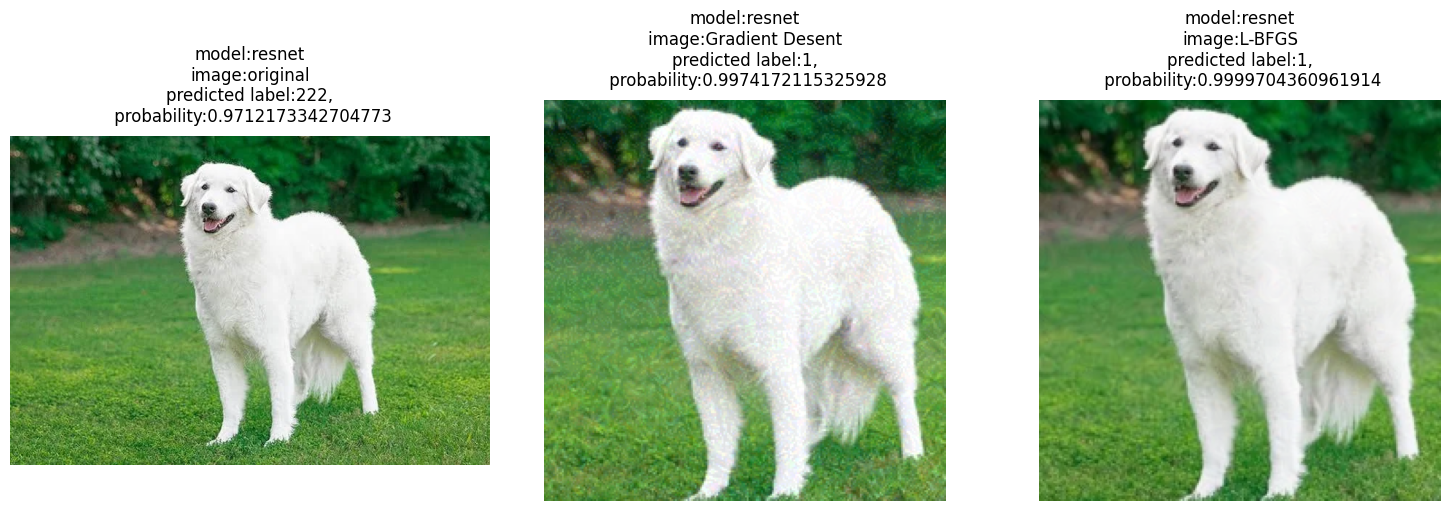

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
import os

files = ["images/Dog.png","images/dog_adv_gd.png","images/dog_adv_bfgs.png"]
imgs = [Image.open(f).convert("RGB") for f in files]

fig, axes = plt.subplots(1, len(imgs), figsize=(5*len(imgs), 5))
if len(imgs) == 1:
    axes = [axes]

c=0
for ax, img, path in zip(axes, imgs, files):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"model:resnet\nimage:{labels[c][0]}\npredicted label:{labels[c][1]},\n probability:{labels[c][2]}", fontsize=12, pad=10)  # title below the image
    c+=1

plt.tight_layout()
plt.show()


In [34]:
import torch
import torch.nn.functional as F

def fgsm_attack(model, image, label=None, epsilon=0.01, device=None):

    # --- pick device ---
    if device is None:
        # prefer device of model parameters/buffers if available
        try:
            device = next(model.parameters()).device
        except StopIteration:
            # model has no params (rare) — prefer MPS if available
            device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

    # move model to device (ensures weights are on device)
    model = model.to(device)
    model.eval()

    # prepare image tensor (batch dim)
    single_input = False
    if image.dim() == 3:  # [C,H,W] -> add batch
        image = image.unsqueeze(0)
        single_input = True

    # move image to device and ensure grad
    image = image.to(device).detach().clone()
    image.requires_grad = True

    # prepare label: if provided move to device and ensure shape [N]
    if label is not None:
        if not torch.is_tensor(label):
            label = torch.tensor([label], device=device)
        else:
            label = label.to(device)
            if label.dim() == 0:
                label = label.unsqueeze(0)
    # if label is None, use model's prediction (untargeted)
    output = model(image)
    if label is None:
        _, pred = output.max(1)
        label = pred

    # compute loss and gradients
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()

    # create perturbation
    data_grad = image.grad
    sign_data_grad = data_grad.sign()
    perturbed = image + epsilon * sign_data_grad

    # clamp (assumes input in [0,1]; if you use mean/std normalization handle separately)
    perturbed = torch.clamp(perturbed, 0.0, 1.0).detach()

    if single_input:
        perturbed = perturbed.squeeze(0)

    return perturbed
adv = fgsm_attack(model, x_raw, label=None, epsilon=0.03)
print(predict_label(model, x_raw.to(next(model.parameters()).device)))   # or use model moved to same device
print(predict_label(model, adv.to(next(model.parameters()).device)))




(222, 0.9712173342704773)
(257, 0.9376288652420044)


### Testing same filters on other models (Alexnet, VGG19)

In [35]:
# checking if same filter work for other models

torch.hub.set_dir(os.path.abspath("alexnet"))   # now torch.hub will use ./resnet50
alex = models.alexnet(pretrained=True) 
alex = alex.to(device)
alex.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

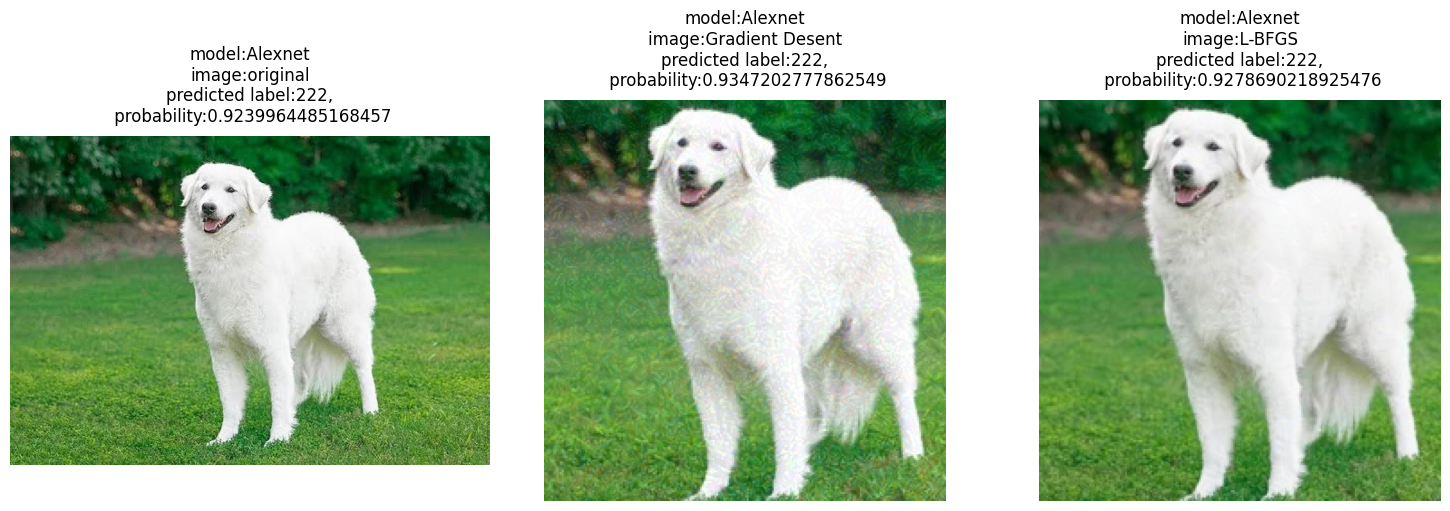

In [36]:
original_pred_prob = predict_label(alex, x_raw)
gd_pred_prob=predict_label(alex, x_adv_gd)
bfgs_pred_prob=predict_label(alex, x_adv_bfgs)


labels=[["original"]+list(original_pred_prob),["Gradient Desent"]+list(gd_pred_prob),["L-BFGS"]+list(bfgs_pred_prob)]

from PIL import Image
import matplotlib.pyplot as plt
import os

files = ["images/Dog.png","images/dog_adv_gd.png","images/dog_adv_bfgs.png"]
imgs = [Image.open(f).convert("RGB") for f in files]

fig, axes = plt.subplots(1, len(imgs), figsize=(5*len(imgs), 5))
if len(imgs) == 1:
    axes = [axes]

c=0
for ax, img, path in zip(axes, imgs, files):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"model:Alexnet\nimage:{labels[c][0]}\npredicted label:{labels[c][1]},\n probability:{labels[c][2]}", fontsize=12, pad=10)  # title below the image
    c+=1

plt.tight_layout()
plt.show()

In [37]:
torch.hub.set_dir(os.path.abspath("vgg19"))   # now torch.hub will use ./resnet50
vgg19 = models.vgg19(pretrained=True) 
vgg19 = vgg19.to(device)
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

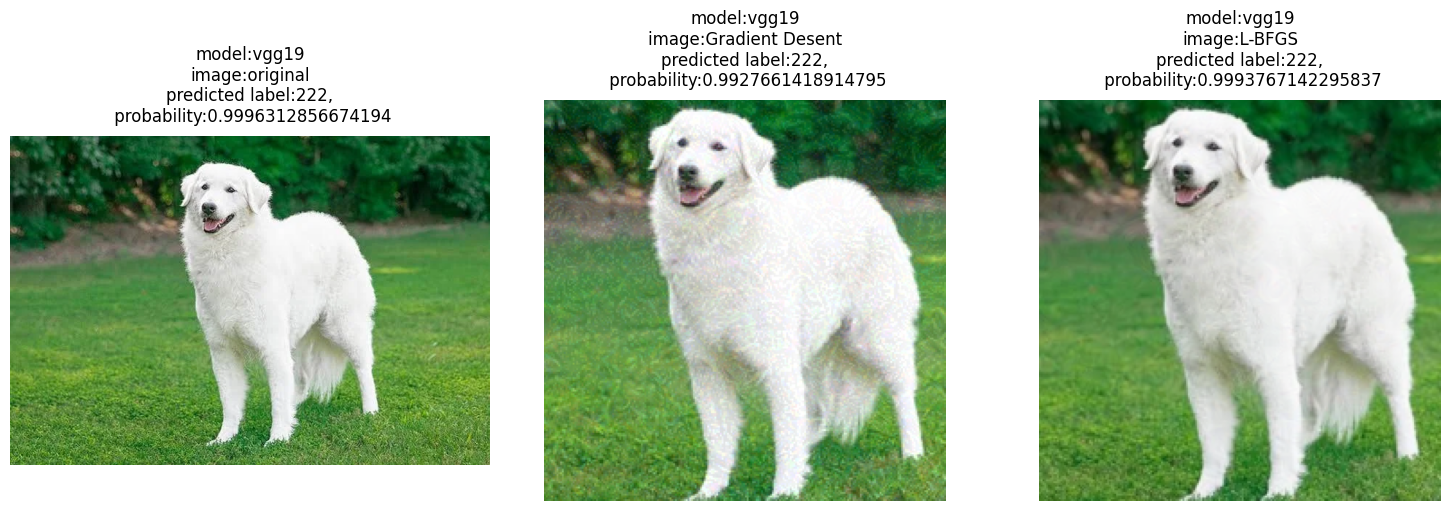

In [38]:
original_pred_prob = predict_label(vgg19, x_raw)
gd_pred_prob=predict_label(vgg19, x_adv_gd)
bfgs_pred_prob=predict_label(vgg19, x_adv_bfgs)


labels=[["original"]+list(original_pred_prob),["Gradient Desent"]+list(gd_pred_prob),["L-BFGS"]+list(bfgs_pred_prob)]

from PIL import Image
import matplotlib.pyplot as plt
import os

files = ["images/Dog.png","images/dog_adv_gd.png","images/dog_adv_bfgs.png"]
imgs = [Image.open(f).convert("RGB") for f in files]

fig, axes = plt.subplots(1, len(imgs), figsize=(5*len(imgs), 5))
if len(imgs) == 1:
    axes = [axes]

c=0
for ax, img, path in zip(axes, imgs, files):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"model:vgg19\nimage:{labels[c][0]}\npredicted label:{labels[c][1]},\n probability:{labels[c][2]}", fontsize=12, pad=10)  # title below the image
    c+=1

plt.tight_layout()
plt.show()